In [ ]:
# import pandas as pd
# import numpy as np
# import numpy.matlib 
# from math import pow

# def createDictionary(criteria='Behaviors'):
    
#     readFileName = ""
#     saveDictName = ""
#     if criteria == 'Behaviors':
#         readFileName = "Behaviors_5.csv"
#         saveDictName = "BehaviorsDict_5.npy"
#     elif criteria == 'Identities':
#         readFileName = "Identities.csv" 
#         saveDictName = "IdentitiesDict.npy"
#     elif criteria == 'Modifiers':
#         readFileName = "Modifiers.csv" 
#         saveDictName = "ModifiersDict.npy"
    
#     df = pd.read_csv(readFileName)
#     #print(df)

#     epaDict = {}
#     for row in df.itertuples():
#         concept = row.concept
#         e = row.me
#         p = row.mp
#         a = row.ma
#         epaDict[concept] = np.array([e,p,a])
#     print(epaDict)    
#     np.save(saveDictName, epaDict) 
#     return epaDict

# createDictionary('Behaviors')

In [ ]:
import pandas as pd
import numpy as np
import numpy.matlib 
from math import pow
import nengo
from sklearn.metrics import mean_squared_error
#from scipy.spatial import distance


from py4j.java_gateway import JavaGateway, GatewayParameters
gateway = JavaGateway(gateway_parameters=GatewayParameters(port=25333))

calcProfile_app = gateway.entry_point
def calcProfile(inAe,inAp,inAa,inBe,inBp,inBa,inOe,inOp,inOa,outAe, outAp, outAa, outBe, outBp, outBa, outOe, outOp, outOa):
    value = calcProfile_app.calcProfile(inAe,inAp,inAa,inBe,inBp,inBa,inOe,inOp,inOa,outAe, outAp, outAa, outBe, outBp, outBa, outOe, outOp, outOa)
    #print(value)
    return value

# This python version is recreated in from Interact Java Program by @author Aarti Malhotra (aarti.malhotra@uwaterloo.ca)

# Function to calculate transients of actor, behavior and object once event has occurred 
# It solves Equation 11.15 for tau and Equation 11.3 for deflection in D. R. Heise, 2007. "Expressive Order: Confirming Sentiments in Social Actions". New York: Springer

def calcTau(modifierIdentifierActorEPA, behaviorEPA, modifierIdentifierObjectEPA):   
    
    inAe = modifierIdentifierActorEPA[0]
    inAp = modifierIdentifierActorEPA[1]
    inAa = modifierIdentifierActorEPA[2]
    inBe = behaviorEPA[0]
    inBp = behaviorEPA[1]
    inBa = behaviorEPA[2]
    inOe = modifierIdentifierObjectEPA[0]
    inOp = modifierIdentifierObjectEPA[1]
    inOa = modifierIdentifierObjectEPA[2]
    
    # Transients preceding the event
    # t = (1 Ae	Ap	Aa	Be	Bp	Ba	Oe	Op	Oa	AeBe	AeOp	ApBp	AaBa	BeOe	BeOp	BpOe	BpOp	AeBeOe	AeBeOp)
    # Note, the initial 1 in column0 is for constant, and starting from column10 is due to M coefficient matrix for ABOmale due to the true positions of index
    # e.g. last column is AeBeOp due to Z100100010 and considering inputs at index which have 1 in (Ae	Ap	Aa	Be	Bp	Ba	Oe	Op	Oa)
    t = np.array([1,inAe,inAp,inAa,inBe,inBp,inBa,inOe,inOp,inOa,inAe*inBe,inAe*inOp,inAp*inBp,inAa*inBa,inBe*inOe,inBe*inOp,inBp*inOe,inBp*inOp,inAe*inBe*inOe,inAe*inBe*inOp]) 

    # Coefficient matrix for ABOmale used from Interact
    M = np.array([[-0.26,-0.1,0.14,-0.19,0.06,0.11,-0.11,-0.37,0.02],
    [0.41,0,0.05,0.11,0,0.02,0,0,0],
    [0,0.56,0,0,0.16,-0.06,0,0,0],
    [0,0.06,0.64,0,0,0.27,0,0,0],
    [0.42,-0.07,-0.06,0.53,-0.13,0.04,0.11,0.18,0.02],
    [-0.02,0.44,0,0,0.7,0,0,-0.11,0],
    [-0.1,0,0.29,-0.12,0,0.64,0,0,0],
    [0.03,0.04,0,0,0.03,0,0.61,-0.08,0.03],
    [0.06,0,0,0.05,0.01,0,0,0.66,-0.05],
    [0,0,0,0,0,0,0.03,0.07,0.66],
    [0.05,0,0,0,0.01,0,0.03,0,0],
    [0.03,0,0,0,0,0,0,0,0],
    [0,-0.05,0,0,0,0,0,0,0],
    [0,0,-0.06,0,0,0,0,0,0],
    [0.12,0.01,0,0.11,0.03,0,0.04,0.03,0],
    [-0.05,0,0,-0.05,0,0,0,0.03,0],
    [-0.05,0,0,-0.02,0,0,-0.03,0,0],
    [0,0,0,0,0,0,0,-0.05,0],
    [0.03,0,0,0.02,0,0,0,0,0],
    [-0.02,0,0,0,0,0,0,0,0]])

    # Transients after the event
    tau = np.dot(t,M)

    outAe = tau[0]
    outAp = tau[1]
    outAa = tau[2]
    outBe = tau[3]
    outBp = tau[4]
    outBa = tau[5]
    outOe = tau[6]
    outOp = tau[7]
    outOa = tau[8]

    # Deflection for actor  
    deflectionA = pow((outAe-inAe), 2)+pow((outAp-inAp), 2)+pow((outAa-inAa), 2)

    # Deflection for object
    deflectionO = pow((outOe-inOe), 2)+pow((outOp-inOp), 2)+pow((outOa-inOa), 2)

    # Deflection overall
    deflectionTotal = deflectionA + pow((outBe-inBe), 2)+pow((outBp-inBp), 2)+pow((outBa-inBa), 2) + deflectionO

    #print("tau=",tau)
    print("deflectionTotal=",deflectionTotal)
    print("deflectionA=",deflectionA)
    print("deflectionO=",deflectionO)

    return tau, deflectionA, deflectionO, deflectionTotal, outAe, outAp, outAa, outBe, outBp, outBa, outOe, outOp, outOa;  


# Function to calculate emotion of actor or object once event has occurred 
# It solves Equation 14.3 in D. R. Heise, 2007. "Expressive Order: Confirming Sentiments in Social Actions". New York: Springer

def calcEmotion(inAe, inAp, inAa, inOe, inOp, inOa, outAe, outAp, outAa, outOe, outOp, outOa, AorO):   
    
    # Coefficient matrix for ABOmale from Interact
    M = np.array([[-0.36,-0.17,-0.22],
    [0.5,0,0],
    [0,0.32,0],
    [-0.23,0,0.44],
    [0.46,0,-0.05],
    [0,0.62,0],
    [0,0,0.66],
    [0.12,0,0.02],
    [0,0.05,0.03]])

    if AorO=='A':
        IReQe = np.array([[M[7][0]*inAe,0,M[8][0]*inAe],[M[7][1]*inAe,0,M[8][1]*inAe],[M[7][2]*inAe,0,M[8][2]*inAe]])
    else:
        IReQe = np.array([[M[7][0]*inOe,0,M[8][0]*inOe],[M[7][1]*inOe,0,M[8][1]*inOe],[M[7][2]*inOe,0,M[8][2]*inOe]])

    IRpQp = np.array([[0,0,0],[0,0,0],[0,0,0]])
    IRaQa = np.array([[0,0,0],[0,0,0],[0,0,0]])

    P = np.array([[0.5,0,-0.23],[0,0.32,0],[0,0,0.44]])
    R = np.array([[0.46,0,0],[0,0.62,0],[-0.05,0,0.66]])

    # Fundamental for Actor or Object
    if AorO=='A':
        r = np.array([inAe, inAp, inAa])
    else:
        r = np.array([inOe, inOp, inOa])

    # P + IRe*Qe + IRp*Qp + IRa*Qa
    P = P + IReQe + IRpQp + IRaQa
    #print("P=",P)

    # inv(P + IRe*Qe + IRp*Qp + IRa*Qa)
    Pinv = np.linalg.inv(P)
    #print("Pinv=",Pinv)

    # tau-d
    if AorO=='A':
        tau_d = np.array([outAe-M[0][0],outAp-M[0][1],outAa-M[0][2]]) 
    else:
        tau_d = np.array([outOe-M[0][0],outOp-M[0][1],outOa-M[0][2]]) 

    #print("tau_d=",tau_d)

    # Rr
    Rr = np.matmul(R,r)
    #print("Rr=",Rr)
    #print("r=",r)

    # tau-d-Rr or tau-Rr-d
    tau_d_Rr = tau_d - Rr
    #print("tau_d_Rr=",tau_d_Rr)  

    # inv(P + IRe*Qe + IRp*Qp + IRa*Qa)*(tau-Rr-d)
    emotionEPA = np.matmul(Pinv,tau_d_Rr)
    print("emotion EPA=",emotionEPA)
    
    distVector = calcDistVector(emotionEPA, 'Modifiers')

    #print(distVector)
    print("Min dist index: ", end ="")
    print(np.argmin(distVector))
    minDist = get_nth_key(np.argmin(distVector),'Modifiers')
    print(" Key: ", end ="")
    print(minDist)

    return minDist;  


# In[24]:


def calcCombinedIdentityModifierEPA(modifierEPA,identityEPA):
    # Coefficient matrix for ABOmale from Interact
    M_0 = np.array([-0.36,-0.17,-0.22])

    # Coefficient matrix for ABOmale from Interact
    M6_1 = np.array([[0.5,0,0],
    [0,0.32,0],
    [-0.23,0,0.44]])

    M6_2 = np.array([[0.46,0,-0.05],
    [0,0.62,0],
    [0,0,0.66]])

    M6_3 = np.array([[0.12,0,0.02],
    [0,0.05,0.03]])
    
    combinedEPA = np.array([0.0, 0.0, 0.0])
    combinedEPA[0] = M_0[0] + M6_1[0][0]*modifierEPA[0] + M6_1[1][0]*modifierEPA[1] + M6_1[2][0]*modifierEPA[2]
    combinedEPA[0] = combinedEPA[0] + M6_2[0][0]*identityEPA[0] + M6_2[1][0]*identityEPA[1] + M6_2[2][0]*identityEPA[2]
    combinedEPA[0] = combinedEPA[0] + M6_3[0][0]*identityEPA[0]*modifierEPA[0] + M6_3[1][0]*identityEPA[0]*modifierEPA[2]

    combinedEPA[1] = M_0[1] + M6_1[0][1]*modifierEPA[0] + M6_1[1][1]*modifierEPA[1] + M6_1[2][1]*modifierEPA[2]
    combinedEPA[1] = combinedEPA[1] + M6_2[0][1]*identityEPA[0] + M6_2[1][1]*identityEPA[1] + M6_2[2][1]*identityEPA[2]
    combinedEPA[1] = combinedEPA[1] + M6_3[0][1]*identityEPA[0]*modifierEPA[0] + M6_3[1][1]*identityEPA[0]*modifierEPA[2]

    combinedEPA[2] = M_0[2] + M6_1[0][2]*modifierEPA[0] + M6_1[1][2]*modifierEPA[1] + M6_1[2][2]*modifierEPA[2]
    combinedEPA[2] = combinedEPA[2] + M6_2[0][2]*identityEPA[0] + M6_2[1][2]*identityEPA[1] + M6_2[2][2]*identityEPA[2]
    combinedEPA[2] = combinedEPA[2] + M6_3[0][2]*identityEPA[0]*modifierEPA[0] + M6_3[1][2]*identityEPA[0]*modifierEPA[2]

    #print("combinedEPA: ",combinedEPA)

    return combinedEPA
  #[0.665408, 0.55376, 0.49194399999999994]


def calcOptNextBehavior(modifierActorEPA, identityActorEPA, behaviorEPA, modifierObjectEPA, identityObjectEPA):

    # combine modifierIdentifierActorEPA
    #print("Calculate modifierIdentifierActorEPA")
    modifierIdentifierActorEPA = calcCombinedIdentityModifierEPA(modifierActorEPA,identityActorEPA)

    # combine modifierIdentifierObjectEPA
    #print("Calculate modifierIdentifierObjectEPA")
    modifierIdentifierObjectEPA = calcCombinedIdentityModifierEPA(modifierObjectEPA,identityObjectEPA)

    # Testing calcTau for scenario from Interact: Mario[_,friend],give a raise to,Player[_,enemy]
    #print("Calling calcTau")
    tau, deflectionA, deflectionO, deflectionTotal, outAe, outAp, outAa, outBe, outBp, outBa, outOe, outOp, outOa = calcTau(modifierIdentifierActorEPA, behaviorEPA, modifierIdentifierObjectEPA)

    #profileValue = calcProfile(0.67,0.55,0.49, -1.40,1.62,1.50, 0.67,0.55,0.49,-0.88,1.02,0.96, -1.11,1.45,1.12, 0.06,-0.55,0.31)
    profileValue = calcProfile(modifierIdentifierActorEPA[0],modifierIdentifierActorEPA[1],modifierIdentifierActorEPA[2], behaviorEPA[0],behaviorEPA[1],behaviorEPA[2],modifierIdentifierObjectEPA[0],modifierIdentifierObjectEPA[1],modifierIdentifierObjectEPA[2],tau[0],tau[1],tau[2],tau[3],tau[4],tau[5],tau[6],tau[7],tau[8])

    #print('calcProfile output Actor Behavior| Object Behavior | Reidentified Actor | Reidentified Object:')
    #print('---------------------------------------------------------------------------------------------')
    #print(profileValue)
    parts = profileValue.split('|')
    objBehaviorEPA = np.array([float(parts[3]),float(parts[4]),float(parts[5])])
        
    print('Object Emotion:')
    print('--------------')
    calcEmotion(modifierIdentifierActorEPA[0],modifierIdentifierActorEPA[1],modifierIdentifierActorEPA[2], modifierIdentifierObjectEPA[0],modifierIdentifierObjectEPA[1],modifierIdentifierObjectEPA[2],outAe, outAp, outAa, outOe, outOp, outOa, 'O')
   
    print('Actor Emotion:')
    print('--------------')
    calcEmotion(modifierIdentifierActorEPA[0],modifierIdentifierActorEPA[1],modifierIdentifierActorEPA[2], modifierIdentifierObjectEPA[0],modifierIdentifierObjectEPA[1],modifierIdentifierObjectEPA[2],outAe, outAp, outAa, outOe, outOp, outOa, 'A')
 
    print('Object next behavior:')
    print('--------------')
    print(objBehaviorEPA)
    
    return objBehaviorEPA

def get_nth_key(n=0, criteria ='Behaviors'):
    
    if criteria == 'Behaviors':
        dictionary = np.load('BehaviorsDict.npy',allow_pickle='TRUE').item()
    elif criteria == 'Identities':
        dictionary = np.load('IdentitiesDict.npy',allow_pickle='TRUE').item()
    elif criteria == 'Modifiers':
        dictionary = np.load('ModifiersDict.npy',allow_pickle='TRUE').item()
    
    if n < 0:
        n += len(dictionary)
    for i, key in enumerate(dictionary.keys()):
        #print(key)
        if i == n:
            return key
    raise IndexError("dictionary index out of range")    


def get_epa_value_for_key(key, criteria ='Behaviors'):
    
    if criteria == 'Behaviors':
        dictionary = np.load('BehaviorsDict.npy',allow_pickle='TRUE').item()
    elif criteria == 'Identities':
        dictionary = np.load('IdentitiesDict.npy',allow_pickle='TRUE').item()
    elif criteria == 'Modifiers':
        dictionary = np.load('ModifiersDict.npy',allow_pickle='TRUE').item()
        
    for k,v in dictionary.items():
        if k == key:
            #print("Found value for: ", end ="")
            #print(key, end ="")
            #print(": ", end ="")
            #print(v)
            return v
    raise IndexError("dictionary does not have this key entry")    

def calcDistVector(epaValue, criteria ='Behaviors'):
  
    distVector = []
    epaDict = {}
        
    # create a map of behaviors epa 
    if criteria == 'Behaviors':
        epaDict = np.load('BehaviorsDict.npy',allow_pickle='TRUE').item()
    elif criteria == 'Identities':
        epaDict = np.load('IdentitiesDict.npy',allow_pickle='TRUE').item()
    elif criteria == 'Modifiers':
        epaDict = np.load('ModifiersDict.npy',allow_pickle='TRUE').item()

    # iterate and calculate array of 500 values which are euclidean distances of objBehaviorEPA from behaviors epa
    for k,v in epaDict.items():
        #print(k)
        distVector.append(np.linalg.norm(epaValue - v))
        
    #print('distVector:')
    #print('----------')
    #print(distVector)
    return distVector


# In[29]:


def calc15InputToBehaviorDistVector(modifierActorEPA, identityActorEPA, behaviorEPA, modifierObjectEPA, identityObjectEPA):
       
    # Test calcOptNextBehavior given 15 inputs
    objBehaviorEPA = calcOptNextBehavior(modifierActorEPA, identityActorEPA, behaviorEPA, modifierObjectEPA, identityObjectEPA)

    # Test calcDistVector
    distVector = calcDistVector(objBehaviorEPA, 'Behaviors')
    return distVector

def calc15PointInputToBehaviorDistVector(maE, maP, maA, iaE, iaP, iaA, bE, bP, bA, moE, moP, moA, ioE, ioP, ioA):
       
    modifierActorEPA = np.array([maE, maP, maA])
    identityActorEPA = np.array([iaE, iaP, iaA])
    behaviorEPA = np.array([bE, bP, bA])
    modifierObjectEPA = np.array([moE, moP, moA])
    identityObjectEPA = np.array([ioE, ioP, ioA])
    # Test calcOptNextBehavior given 15 inputs
    objBehaviorEPA = calcOptNextBehavior(modifierActorEPA, identityActorEPA, behaviorEPA, modifierObjectEPA, identityObjectEPA)

    # Test calcDistVector
    distVector = calcDistVector(objBehaviorEPA, 'Behaviors')
    return distVector
    
def testcalc15PointInputToBehaviorDistVector():
       
    modifierActorEPA = np.array([2.92,2.43,1.96])
    identityActorEPA = np.array([0.02,-0.09,-0.23])
    behaviorEPA = np.array([-1.40, 1.62, 1.50])
    modifierObjectEPA = np.array([2.92,2.43,1.96])
    identityObjectEPA = np.array([0.02,-0.09,-0.23])
    # Test calcOptNextBehavior given 15 inputs
    objBehaviorEPA = calcOptNextBehavior(modifierActorEPA, identityActorEPA, behaviorEPA, modifierObjectEPA, identityObjectEPA)

    # Test calcDistVector
    distVector = calcDistVector(objBehaviorEPA, 'Behaviors')
    return distVector
# In[30]:


#Try loading epa for a behavior
# epaBehaviorDict = createDictionary('Behaviors')
# epaModifiersDict = createDictionary('Modifiers')
# epaIdentitiesDict = createDictionary('Identities')

def calcNengoEvalPointsFromInputFile(filename = 'eval_scenarios.csv'):
    
    df = pd.read_csv(filename)
    print(df)
    
    nengoEvalPointsArr = np.array([])
    
    for index, row in df.iterrows():
     # access data using column names
      #  print(index, row['modA'], row['idA'], row['behavior'], row['modO'], row['idO'])
    
        modifierActorEPA = get_epa_value_for_key(row['modA'], 'Modifiers')
        identityActorEPA = get_epa_value_for_key(row['idA'], 'Identities')
        behaviorEPA = get_epa_value_for_key(row['behavior'], 'Behaviors')
        modifierObjectEPA = get_epa_value_for_key(row['modO'], 'Modifiers')
        identityObjectEPA = get_epa_value_for_key(row['idO'], 'Identities')

        evalPoint = np.array([modifierActorEPA,identityActorEPA,behaviorEPA,modifierObjectEPA,identityObjectEPA])

        nengoEvalPointsArr.append(identityObjectEPA)

    return nengoEvalPointsArr

def calcOneInteractionRound(modifierActor, identityActor, behavior, modifierObject, identityObject):
    modifierActorEPA = get_epa_value_for_key(modifierActor, 'Modifiers')
    identityActorEPA = get_epa_value_for_key(identityActor, 'Identities')
    behaviorEPA = get_epa_value_for_key(behavior, 'Behaviors')
    modifierObjectEPA = get_epa_value_for_key(modifierObject, 'Modifiers')
    identityObjectEPA = get_epa_value_for_key(identityObject, 'Identities')
    
    print(modifierActor, end ="") 
    print(" ", end ="") 
    print(identityActor, end ="") 
    print(" ", end ="") 
    print(behavior, end ="") 
    print(" ", end ="") 
    print(modifierObject, end ="") 
    print(" ", end ="") 
    print(identityObject)
    print(modifierActorEPA, end ="") 
    print(" ", end ="") 
    print(identityActorEPA, end ="") 
    print(" ", end ="") 
    print(behaviorEPA, end ="") 
    print(" ", end ="") 
    print(modifierObjectEPA, end ="") 
    print(" ", end ="") 
    print(identityObjectEPA)
    
    distVector = calc15InputToBehaviorDistVector(modifierActorEPA, identityActorEPA, behaviorEPA, modifierObjectEPA, identityObjectEPA)

    print("Min dist index: ", end ="")
    print(np.argmin(distVector))
    minDist = get_nth_key(np.argmin(distVector),'Behaviors')
    print(" Key: ", end ="")
    print(minDist)
    
model = nengo.Network(label='Basal Ganglia', seed = 3)
with model:
    print('Hello Nengo!')


def calcEPAError(expectedEPA,actualEPA):
    mse = mean_squared_error(expectedEPA, actualEPA)
    print(mse)
    
# def calcEPADist(expectedEPA,actualEPA):
#     mse = distance.euclidean(expectedEPA, actualEPA)
#     print(mse)

def calcEPADistNorm(expectedEPA,actualEPA):
    mse = np.linalg.norm(expectedEPA - actualEPA)
    print(mse)    
    
def calc15EPAError(expected15EPA,actual15EPA):
    mse = mean_squared_error(expected15EPA, actual15EPA)
    print(mse)

def calcNengoEvalPointsFromInputFile(filename = 'eval_scenarios.csv'):
    
    df = pd.read_csv(filename)
    print(df)
    
    nengoEvalPointsArr = []
    
    for index, row in df.iterrows():
     # access data using column names
      #  print(index, row['modA'], row['idA'], row['behavior'], row['modO'], row['idO'])
    
        modifierActorEPA = get_epa_value_for_key(row['modA'], 'Modifiers')
        identityActorEPA = get_epa_value_for_key(row['idA'], 'Identities')
        behaviorEPA = get_epa_value_for_key(row['behavior'], 'Behaviors')
        modifierObjectEPA = get_epa_value_for_key(row['modO'], 'Modifiers')
        identityObjectEPA = get_epa_value_for_key(row['idO'], 'Identities')

        evalPoint = [modifierActorEPA[0],modifierActorEPA[1],modifierActorEPA[2],
                     identityActorEPA[0],identityActorEPA[1],identityActorEPA[2],
                     behaviorEPA[0],behaviorEPA[1],behaviorEPA[2],
                     modifierObjectEPA[0],modifierObjectEPA[1],modifierObjectEPA[2],
                     identityObjectEPA[0],identityObjectEPA[1],identityObjectEPA[2]]
        print(evalPoint)
        
        nengoEvalPointsArr.append(evalPoint)

    return nengoEvalPointsArr

Hello Nengo!


In [ ]:
calcNengoEvalPointsFromInputFile()
# earlier ones
# happy,father,cuddle,happy,son
# angry,father,shout at,happy,son
# happy,father,cheer,sad,son
# happy,father,advise,fearful,son
# angry,son,insult,angry,father
# happy,stranger,sell something to,happy,stranger
# happy,stranger,capture,happy,stranger
# angry,stranger,capture,happy,stranger
# fearful,stranger,sell something to,angry,stranger
# angry,stranger,capture,fearful,stranger

    modA       idA           behavior   modO       idO
0  happy  stranger  sell something to  happy  stranger
1  angry  stranger  sell something to  happy  stranger
2  happy  stranger            capture  happy  stranger
3  angry  stranger            capture  happy  stranger
[2.92, 2.43, 1.96, 0.02, -0.09, -0.23, 1.6, 1.47, 1.55, 2.92, 2.43, 1.96, 0.02, -0.09, -0.23]
[-1.45, -0.3, 1.13, 0.02, -0.09, -0.23, 1.6, 1.47, 1.55, 2.92, 2.43, 1.96, 0.02, -0.09, -0.23]
[2.92, 2.43, 1.96, 0.02, -0.09, -0.23, -1.4, 1.62, 1.5, 2.92, 2.43, 1.96, 0.02, -0.09, -0.23]
[-1.45, -0.3, 1.13, 0.02, -0.09, -0.23, -1.4, 1.62, 1.5, 2.92, 2.43, 1.96, 0.02, -0.09, -0.23]


[[2.92,
  2.43,
  1.96,
  0.02,
  -0.09,
  -0.23,
  1.6,
  1.47,
  1.55,
  2.92,
  2.43,
  1.96,
  0.02,
  -0.09,
  -0.23],
 [-1.45,
  -0.3,
  1.13,
  0.02,
  -0.09,
  -0.23,
  1.6,
  1.47,
  1.55,
  2.92,
  2.43,
  1.96,
  0.02,
  -0.09,
  -0.23],
 [2.92,
  2.43,
  1.96,
  0.02,
  -0.09,
  -0.23,
  -1.4,
  1.62,
  1.5,
  2.92,
  2.43,
  1.96,
  0.02,
  -0.09,
  -0.23],
 [-1.45,
  -0.3,
  1.13,
  0.02,
  -0.09,
  -0.23,
  -1.4,
  1.62,
  1.5,
  2.92,
  2.43,
  1.96,
  0.02,
  -0.09,
  -0.23]]

In [ ]:
import nengo
import nengo.spa as spa
import numpy as np

D = 3  # the dimensionality of the vectors

behaviorsDict = np.load('BehaviorsDict.npy',allow_pickle='TRUE').item()
vocab_behaviors = spa.Vocabulary(dimensions=3)
for key, value in behaviorsDict.items():
    vocab_behaviors.add(key.upper().replace(' ', '_'), value)
    
modifiersDict = np.load('ModifiersDict.npy',allow_pickle='TRUE').item()
vocab_modifiers = spa.Vocabulary(dimensions=3)
for key, value in modifiersDict.items():
    vocab_modifiers.add(key.upper(), value)
    
identitiesDict = np.load('IdentitiesDict.npy',allow_pickle='TRUE').item()
vocab_identities = spa.Vocabulary(dimensions=3)
for key, value in identitiesDict.items():
    vocab_identities.add(key.upper(), value)




In [ ]:
# calcOneInteractionRound('happy', 'father', 'cuddle', 'happy', 'son')
#calcOneInteractionRound('happy', 'stranger', 'capture', 'happy', 'stranger')
#calcOneInteractionRound('angry', 'father', 'shout at', 'happy', 'son')
# calcOneInteractionRound('happy', 'father', 'cuddle', 'happy', 'son')
# calcOneInteractionRound('angry', 'father', 'fight', 'angry', 'son')
# calcOneInteractionRound('happy', 'father', 'cheer', 'sad', 'son')
# calcOneInteractionRound('happy', 'father', 'advise', 'fearful', 'son')
# calcOneInteractionRound('angry', 'son', 'insult', 'angry', 'father')
calcOneInteractionRound('happy', 'stranger', 'sell something to', 'happy', 'stranger')
calcOneInteractionRound('angry', 'stranger', 'sell something to', 'happy', 'stranger')
# calcOneInteractionRound('happy', 'stranger', 'capture', 'happy', 'stranger')
# calcOneInteractionRound('angry', 'stranger', 'capture', 'happy', 'stranger')

# calcOneInteractionRound('no emotion', 'doctor', 'instruct', 'no emotion', 'patient')

happy stranger sell something to happy stranger
[2.92 2.43 1.96] [ 0.02 -0.09 -0.23] [1.6  1.47 1.55] [2.92 2.43 1.96] [ 0.02 -0.09 -0.23]
deflectionTotal= 1.5413936937865222
deflectionA= 0.1395656534355008
deflectionO= 0.22041769009521053
Object Emotion:
--------------
emotion EPA= [ 1.25239687 -0.22763794  0.61065348]
Min dist index: 99
 Key: female
Actor Emotion:
--------------
emotion EPA= [1.83813255 1.70943844 1.52184007]
Min dist index: 160
 Key: jubilant
Object next behavior:
--------------
[0.82399679 0.66213742 0.19954343]
Min dist index: 10
 Key: analyze
angry stranger sell something to happy stranger
[-1.45 -0.3   1.13] [ 0.02 -0.09 -0.23] [1.6  1.47 1.55] [2.92 2.43 1.96] [ 0.02 -0.09 -0.23]
deflectionTotal= 3.7120249849000975
deflectionA= 1.4679020529243327
deflectionO= 0.255380214649192
Object Emotion:
--------------
emotion EPA= [ 1.08833952 -0.22813146  0.61540018]
Min dist index: 99
 Key: female
Actor Emotion:
--------------
emotion EPA= [2.83794745 2.49930883 1.60451

In [ ]:
model = spa.SPA()
with model:
     
    model.vision1 = spa.State(D, vocab=vocab_modifiers, neurons_per_dimension=200)
    model.vision2 = spa.State(D, vocab=vocab_identities, neurons_per_dimension=200)
    #for ens in model.vision2.all_ensembles:
        #ens.neuron_type = nengo.Direct()
        #print(ens, ens.n_neurons)
    model.vision3 = spa.State(D, vocab=vocab_behaviors, neurons_per_dimension=200)
    model.vision4 = spa.State(D, vocab=vocab_modifiers, neurons_per_dimension=200)
    model.vision5 = spa.State(D, vocab=vocab_identities, neurons_per_dimension=200)
    
    for ens in model.vision1.all_ensembles:
        ens.radius=4.3 #2*4.3*np.sqrt(3)
        
    for ens in model.vision2.all_ensembles:
        ens.radius=4.3 #2*4.3*np.sqrt(3)
        
    for ens in model.vision3.all_ensembles:
        ens.radius=4.3 #2*4.3*np.sqrt(3)
    
    for ens in model.vision4.all_ensembles:
        ens.radius=4.3 #2*4.3*np.sqrt(3)
        
    for ens in model.vision5.all_ensembles:
        ens.radius=4.3 #2*4.3*np.sqrt(3)

    #model.memory = spa.State(D, feedback=1)

    #nengo.Connection(model.vision1.output, model.memory.input,
    #                 transform=0.1)
                     
        
    def vision1_input(t):
        if t < 0.5:
            return 'HAPPY'
        else:
            return 'ANGRY'
        
    def vision2_input(t):
        if t < 0.5:
            return 'STRANGER'
        else:
            return 'STRANGER'
        
    # 'SELL_SOMETHING_TO'
    # 'CAPTURE'
    def vision3_input(t):
        if t < 0.5:
            return 'SELL_SOMETHING_TO'
        else:
            return 'SELL_SOMETHING_TO'       

    def vision4_input(t):
        if t < 0.5:
            return 'HAPPY'
        else:
            return 'HAPPY'

    def vision5_input(t):
        if t < 0.5:
            return 'STRANGER'
        else:
            return 'STRANGER'  
        
#    model.stim = spa.Input(vision1='HAPPY', vision2='STRANGER', vision3='CAPTURE', vision4='HAPPY', vision5='STRANGER')
    model.stim = spa.Input(vision1=vision1_input, vision2=vision2_input, vision3=vision3_input, 
                           vision4=vision4_input, vision5=vision5_input)
#  0  happy  stranger  sell something to  happy  stranger
# 1  angry  stranger  sell something to  happy  stranger
# 2  happy  stranger            capture  happy  stranger
# 3  angry  stranger            capture  happy  stranger
# [2.92, 2.43, 1.96, 0.02, -0.09, -0.23, 1.6, 1.47, 1.55, 2.92, 2.43, 1.96, 0.02, -0.09, -0.23]
# [-1.45, -0.3, 1.13, 0.02, -0.09, -0.23, 1.6, 1.47, 1.55, 2.92, 2.43, 1.96, 0.02, -0.09, -0.23]
# [2.92, 2.43, 1.96, 0.02, -0.09, -0.23, -1.4, 1.62, 1.5, 2.92, 2.43, 1.96, 0.02, -0.09, -0.23]
# [-1.45, -0.3, 1.13, 0.02, -0.09, -0.23, -1.4, 1.62, 1.5, 2.92, 2.43, 1.96, 0.02, -0.09, -0.23]

    
    p1 = nengo.Probe(model.vision1.output)
    p2 = nengo.Probe(model.vision2.output)
    p3 = nengo.Probe(model.vision3.output)
    p4 = nengo.Probe(model.vision4.output)
    p5 = nengo.Probe(model.vision5.output)
    
    #combined = nengo.Ensemble(n_neurons=500, dimensions=15)
    combined = nengo.Ensemble(n_neurons=1500, dimensions=15,radius=4.3*np.sqrt(15))#, neuron_type=nengo.Direct(),radius=4.3)
    nengo.Connection(model.vision1.output, combined[[0,1,2]])
    nengo.Connection(model.vision2.output, combined[[3,4,5]])
    nengo.Connection(model.vision3.output, combined[[6,7,8]])
    nengo.Connection(model.vision4.output, combined[[9,10,11]])
    nengo.Connection(model.vision5.output, combined[[12,13,14]])

    pC = nengo.Probe(combined)
    pC_neurons = nengo.Probe(combined.neurons)
    p_input = nengo.Probe(combined, 'input')
    
    bg = nengo.networks.BasalGanglia(dimensions=500)

    maximum_distance = 5.0
    nengo.Connection(combined,bg.input, 
            eval_points=np.array([[2.92, 2.43, 1.96, 0.02, -0.09, -0.23, 1.6 , 1.47 ,1.55,2.92, 2.43, 1.96, 0.02, -0.09, -0.23]
                                ,[-1.45, -0.3, 1.13, 0.02, -0.09, -0.23, 1.6 , 1.47 ,1.55,2.92, 2.43, 1.96, 0.02, -0.09, -0.23]
                                          ]),
                      function=lambda x: np.interp(calc15PointInputToBehaviorDistVector(*x), [1.5, maximum_distance], [1, 0]),
                      scale_eval_points=False)
   
    # [0. 0. 0.] [1.9  0.69 0.05] [1.85 1.65 0.3 ] [0. 0. 0.] [ 0.9  -0.69 -1.05]
#                          eval_points=np.array([[2.92, 2.43, 1.96, 0.02, -0.09, -0.23, -1.4, 1.62, 1.5, 2.92, 2.43, 1.96, 0.02, -0.09, -0.23]
#                                           ,[-1.45, -0.3, 1.13, 0.02, -0.09, -0.23, -1.4, 1.62, 1.5, 2.92, 2.43, 1.96, 0.02, -0.09, -0.23]
#                                           ]),
        
    def inhibit(t):
#         if t<0.5:
#             return [0]*500
#         else:
            value = [-10]*500 # default all inhibit
            value[68] = 0   #obey  # allow 'capture' -> underpay -2.25,  -0.57,  -0.57 take
            value[408] = 0   #disobey # allow 'sell something to' -> compensate 2.28   1.51   0.82 give
            return value
    
#     p_bginAll = nengo.Probe(bg.input)
#     p_bgoutAll = nengo.Probe(bg.output)
        
    inhibitor = nengo.Node(inhibit)
    nengo.Connection(inhibitor, bg.input)
            
    
    p_bgin = nengo.Probe(bg.input)    
    p_bgout = nengo.Probe(bg.output)
    
    thal = nengo.networks.Thalamus(dimensions=500)
    nengo.Connection(bg.output, thal.input)
    
    p_thal = nengo.Probe(thal.output, synapse=0.03) 


deflectionTotal= 1.5413936937865222
deflectionA= 0.1395656534355008
deflectionO= 0.22041769009521053
Object Emotion:
--------------
emotion EPA= [ 1.25239687 -0.22763794  0.61065348]
Min dist index: 99
 Key: female
Actor Emotion:
--------------
emotion EPA= [1.83813255 1.70943844 1.52184007]
Min dist index: 160
 Key: jubilant
Object next behavior:
--------------
[0.82399679 0.66213742 0.19954343]


In [ ]:
sim = nengo.Simulator(model)
sim.run(1.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

deflectionTotal= 1.5413936937865222
deflectionA= 0.1395656534355008
deflectionO= 0.22041769009521053
Object Emotion:
--------------
emotion EPA= [ 1.25239687 -0.22763794  0.61065348]
Min dist index: 99
 Key: female
Actor Emotion:
--------------
emotion EPA= [1.83813255 1.70943844 1.52184007]
Min dist index: 160
 Key: jubilant
Object next behavior:
--------------
[0.82399679 0.66213742 0.19954343]
deflectionTotal= 3.7120249849000975
deflectionA= 1.4679020529243327
deflectionO= 0.255380214649192
Object Emotion:
--------------
emotion EPA= [ 1.08833952 -0.22813146  0.61540018]
Min dist index: 99
 Key: female
Actor Emotion:
--------------
emotion EPA= [2.83794745 2.49930883 1.60451402]
Min dist index: 111
 Key: glad
Object next behavior:
--------------
[0.06602865 0.97940046 0.06056424]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

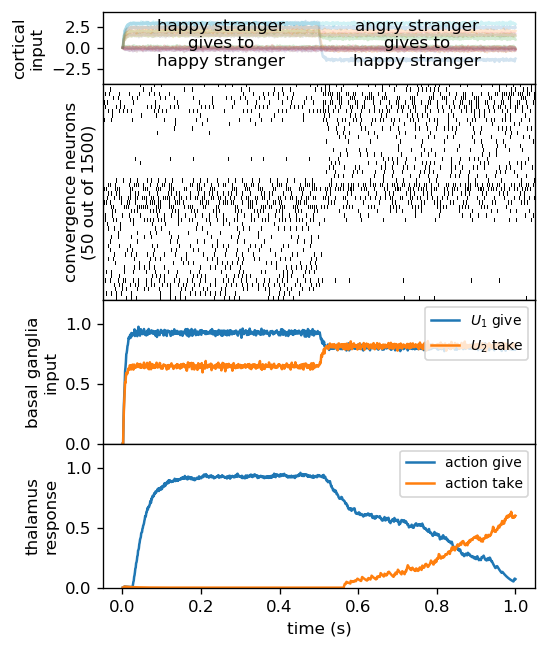

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,6), dpi=120)

ax = plt.axes([0.1, 0.8, 0.9, 0.1])
plt.plot(sim.trange(), sim.data[p_input], alpha=0.2)
plt.text(0.25, 0.5, 'happy stranger\ngives to\nhappy stranger', va='center', ha='center')
plt.text(0.75, 0.5, 'angry stranger\ngives to\nhappy stranger', va='center', ha='center')
# plt.text(0.5, 0.75, 'doctor instructs patient', va='center', ha='center')
plt.ylabel('cortical\ninput')
plt.xticks([])
# plt.yticks([])
plt.ylim(-4.3,4.3)


ax = plt.axes([0.1, 0.5, 0.9, 0.3])

import nengo_extras.plot_spikes as ps
ps.plot_spikes(
    *ps.merge(
        *ps.cluster(
            *ps.sample_by_variance(
                sim.trange(), sim.data[pC_neurons],
                num=50, filter_width=.02),
            filter_width=.002),
        num=50))
plt.xticks([])
plt.yticks([])
plt.ylabel('convergence neurons\n(50 out of 1500)')

ax = plt.axes([0.1, 0.3, 0.9, 0.2])
plt.plot(sim.trange(), sim.data[p_bgin][:,408])
plt.plot(sim.trange(), sim.data[p_bgin][:,68])
plt.xticks([])
plt.ylabel('basal ganglia\ninput')
# plt.yticks([])
plt.ylim(0,1.2)
plt.legend(['$U_1$ give', '$U_2$ take'], loc='upper right', fontsize='smaller')

ax = plt.axes([0.1, 0.1, 0.9, 0.2])
plt.plot(sim.trange(), sim.data[p_thal][:,408])
plt.plot(sim.trange(), sim.data[p_thal][:,68])

plt.ylabel('thalamus\nresponse')
# plt.yticks([])
plt.ylim(0,1.2)
plt.legend(['action give', 'action take'], loc='upper right', fontsize='smaller')
plt.xlabel('time (s)')
plt.savefig('simulation-give.png', dpi=1200,bbox_inches='tight')
plt.show()

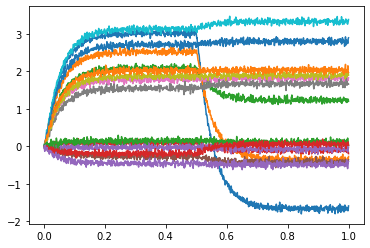

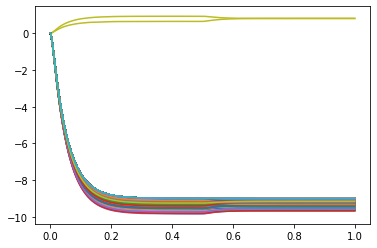

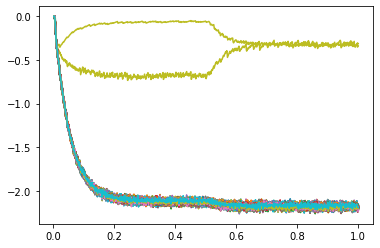

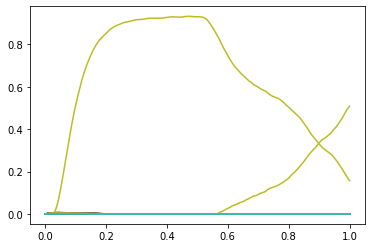

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

filt = nengo.synapses.Lowpass(0.05)

#plt.plot(sim.trange(), filt.filt(sim.data[p2]))
#plt.legend(['E','P','A'])
epaDict = np.load('BehaviorsDict.npy',allow_pickle='TRUE').item()

plt.plot(sim.trange(), filt.filt(sim.data[pC]))
plt.figure()

plt.plot(sim.trange(), filt.filt(sim.data[p_bgin]))
#plt.legend(list(epaDict.keys()))
plt.figure()

plt.plot(sim.trange(), filt.filt(sim.data[p_bgout]))
#plt.legend(list(epaDict.keys()))
plt.show()

plt.plot(sim.trange(), filt.filt(sim.data[p_thal]))
# plt.legend(['correct', 'exonerate', 'lend money to', 'reproach', 'stop'])
#plt.legend(list(epaDict.keys()))
plt.show()

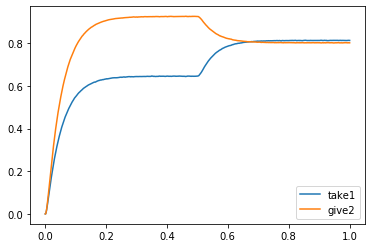

In [ ]:
plt.plot(sim.trange(), filt.filt(sim.data[p_bgin])[:,68],label='take1')
plt.plot(sim.trange(), filt.filt(sim.data[p_bgin])[:,408],label='give2')
plt.legend()
plt.show()

In [ ]:
np.argmax(np.mean(filt.filt(sim.data[p_thal][0:500]), axis=0))

408

In [ ]:
list(epaDict.keys())[323]

'obey'

In [ ]:
np.argmax(np.mean(filt.filt(sim.data[p_thal][800:1000]), axis=0))

68

In [ ]:
list(epaDict.keys())[480]

'underpay'

In [ ]:
#epaDict = np.load('BehaviorsDict.npy',allow_pickle='TRUE').item()
list(epaDict.keys())[408]

'sell something to'

In [ ]:
list(epaDict.keys())[0]

In [ ]:
list(epaDict.keys())[282]

In [ ]:
np.mean(filt.filt(sim.data[p1])[500:], axis=0)
# 2.92, 2.43, 1.96

In [ ]:
np.mean(filt.filt(sim.data[p2])[500:], axis=0)
# 0.02, -0.09, -0.23

In [ ]:
np.mean(filt.filt(sim.data[p3])[500:], axis=0)
# -1.4 ,  1.62,  1.5

In [ ]:
np.mean(filt.filt(sim.data[p4])[500:], axis=0)
# 2.92, 2.43, 1.96

In [ ]:
np.mean(filt.filt(sim.data[p5])[500:], axis=0)
# 0.02, -0.09, -0.23

In [ ]:
np.mean(filt.filt(sim.data[pC])[500:], axis=0)
# 2.92, 2.43, 1.96 | 0.02, -0.09, -0.23 | -1.4 ,  1.62,  1.5 | 2.92, 2.43, 1.96 | 0.02, -0.09, -0.23

In [ ]:
expected15EPA = np.array([2.92, 2.43, 1.96 , 0.02, -0.09, -0.23 , -1.4 ,  1.62,  1.5 , 2.92, 2.43, 1.96 , 0.02, -0.09, -0.23])
actual15EPA = np.array([2.89531163,  2.38366682,  1.91647332,  0.01126185, -0.07262205,
       -0.23894168, -1.43521502,  1.62924219,  1.48672689,  2.85577178,
        2.35426866,  1.96934229, -0.02432075, -0.08330136, -0.21271077])
arr = np.interp(calc15PointInputToBehaviorDistVector(*expected15EPA), [0, 1.0], [1, 0])
print(arr[176])

deflectionTotal= 4.68541485487331
deflectionA= 2.815036245973727
deflectionO= 1.6184305467748878
Object Emotion:
--------------
emotion EPA= [ 0.39522824 -2.31158629  0.50500858]
Min dist index: 99
 Key: female
Actor Emotion:
--------------
emotion EPA= [-0.64016499  2.45137926  1.95656578]
Min dist index: 23
 Key: authoritarian
Object next behavior:
--------------
[0.38934866 1.44826028 0.09001935]
0.5820382609935563


In [ ]:
print(arr[379])

In [ ]:
#print(np.argsort(arr))

In [ ]:
from sklearn.metrics import mean_squared_error
#from scipy.spatial import distance
import numpy as np

def calcEPAError(expectedEPA,actualEPA):
    mse = mean_squared_error(expectedEPA, actualEPA)
    print(mse)
    
# def calcEPADist(expectedEPA,actualEPA):
#     mse = distance.euclidean(expectedEPA, actualEPA)
#     print(mse)

def calcEPADistNorm(expectedEPA,actualEPA):
    mse = np.linalg.norm(expectedEPA - actualEPA)
    print(mse)    
    
def calc15EPAError(expected15EPA,actual15EPA):
    mse = mean_squared_error(expected15EPA, actual15EPA)
    print(mse)

# 0  happy  stranger  sell something to  happy  stranger [0.82399679 0.66213742 0.19954343]
# 1  angry  stranger  sell something to  happy  stranger [0.06602865 0.97940046 0.06056424]
# 2  happy  stranger            capture  happy  stranger [0.38934866 1.44826028 0.09001935]
# 3  angry  stranger            capture  happy  stranger [-0.17677105  1.66239934  0.16989885]

HSGHS = [0.82399679, 0.66213742, 0.19954343]
ASGHS = [0.06602865, 0.97940046, 0.06056424]
HSTHS = [0.38934866, 1.44826028, 0.09001935]
ASTHS = [-0.17677105,  1.66239934,  0.16989885]
giveEPA = np.array([1.60, 1.47, 1.55])
takeEPA = np.array([-1.40, 1.62, 1.50])

print('HSGHS')
calcEPADistNorm(HSGHS,giveEPA)  
calcEPADistNorm(HSGHS,takeEPA) 

print('ASGHS')
calcEPADistNorm(ASGHS,giveEPA)  
calcEPADistNorm(ASGHS,takeEPA)  

print('HSTHS')
calcEPADistNorm(HSTHS,giveEPA)  
calcEPADistNorm(HSTHS,takeEPA)  

print('ASTHS')
calcEPADistNorm(ASTHS,giveEPA)  
calcEPADistNorm(ASTHS,takeEPA)  

# expectedEPA = np.array([1.60, 1.47, 1.55])
# actualEPA = np.array([0.066, 0.98, 0.06])
# #calcEPAError(expectedEPA,actualEPA) 
# # calcEPADist(expectedEPA,actualEPA)  
# calcEPADistNorm(expectedEPA,actualEPA)  

# expectedEPA = np.array([-1.40, 1.62, 1.50])
# actualEPA = np.array([0.066, 0.98, 0.06])
# #calcEPAError(expectedEPA,actualEPA)
# # calcEPADist(expectedEPA,actualEPA) 
# calcEPADistNorm(expectedEPA,actualEPA)  


# expected15EPA = np.array([2.92, 2.43, 1.96 , 0.02, -0.09, -0.23 , -1.4 ,  1.62,  1.5 , 2.92, 2.43, 1.96 , 0.02, -0.09, -0.23])
# actual15EPA = np.array([2.89531163,  2.38366682,  1.91647332,  0.01126185, -0.07262205,
#        -0.23894168, -1.43521502,  1.62924219,  1.48672689,  2.85577178,
#         2.35426866,  1.96934229, -0.02432075, -0.08330136, -0.21271077])
# calc15EPAError(expected15EPA,actual15EPA)  

HSGHS
1.7545813966729287
2.7486086906925706
ASGHS
2.193666997161559
2.152111307631604
HSTHS
1.8967584930201042
2.2845806161840505
ASTHS
2.2580106408920795
1.807555210050819


In [ ]:
modifiersDict['no emotion'] #-1.45, -0.3 ,  1.13, 2.48, 1.96, 1.15, -1.08,  0.85,  1.89, 1.87, 0.82, 1.69, 1.45, -0.76,  2.1

array([0., 0., 0.])

In [ ]:
identitiesDict['child']

In [ ]:
behaviorsDict['obey']

array([ 0.58, -0.52, -0.95])

In [ ]:
max(np.mean(filt.filt(sim.data[p_thal])[500:], axis=0))

In [ ]:
np.argmax(np.mean(filt.filt(sim.data[p_thal])[500:], axis=0))

In [ ]:
np.interp(, [0, 4.3], [1, 0])

In [ ]:
max(np.mean(filt.filt(sim.data[p_bgout])[500:], axis=0))

In [ ]:
np.argmax(np.mean(filt.filt(sim.data[p_bgout])[500:], axis=0))

In [ ]:
max(np.mean(filt.filt(sim.data[p_bgin])[500:], axis=0))

In [ ]:
np.argmax(np.mean(filt.filt(sim.data[p_bgin])[500:], axis=0))

In [ ]:
max(np.mean(filt.filt(sim.data[pC])[500:], axis=0))

In [ ]:
np.argmax(np.mean(filt.filt(sim.data[pC])[500:], axis=0))

In [ ]:
vocab_behaviors.parse("CAPTURE").v

In [ ]:
behaviorsDict['intelligent']

KeyError: 'intelligent'

In [ ]:
vocab_behaviors.parse("SELL_SOMETHING_TO").v

array([-2.25, -0.57, -0.57])

In [ ]:
behaviorsDict['shout at']

In [ ]:
def testInhibit(t):
    if t<0.5:
        return [0]*4
    else:
        value = [-100]*4 # default all inhibit
        value[1] = 0     # allow 'capture'
        value[3] = 0    # allow 'sell something to'
        return value
print(testInhibit(0.2))
test= np.interp(testInhibit(0.2), [0, maximum_distance], [1, 0])
print(test)

print(testInhibit(0.5))
test= np.interp(testInhibit(0.5), [0, maximum_distance], [1, 0])
print(test)

[0, 0, 0, 0]
[1. 1. 1. 1.]
[-100, 0, -100, 0]
[1. 1. 1. 1.]
